In [1]:
# 基本模块导入
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

import warnings
warnings.filterwarnings('ignore')

## 读取数据

In [2]:
data = pd.read_csv('../Data/bmi.csv')
data.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


## 数据查看

In [3]:
# 数据查看
data.describe(include='all')

,Gender,Height,Weight,Index
count,500,500.000000,500.000000,500.000000
unique,2,NaN,NaN,NaN
top,Female,NaN,NaN,NaN
freq,255,NaN,NaN,NaN
mean,NaN,169.944000,106.000000,3.748000
std,NaN,16.375261,32.382607,1.355053
min,NaN,140.000000,50.000000,0.000000
25%,NaN,156.000000,80.000000,3.000000
50%,NaN,170.500000,106.000000,4.000000
75%,NaN,184.000000,136.000000,5.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
Gender    500 non-null object
Height    500 non-null int64
Weight    500 non-null int64
Index     500 non-null int64
dtypes: int64(3), object(1)
memory usage: 15.8+ KB


In [5]:
data.isnull().sum()

Gender    0
Height    0
Weight    0
Index     0
dtype: int64

## 处理'Index'列

In [6]:
# 把‘Index’特征值用文字叙述，方便之后的数据分析
data_ana = data.copy(deep=True)
data_ana['Index'] = pd.Categorical(data['Index'], categories=[0,1,2,3,4,5], ordered=True)
ind_dict = {0: 'Extremely Weak',
            1: 'Weak',
            2: 'Normal',
            3:'Overweight',
            4: 'Obesity',
            5: 'Extreme Obesity'}
data_ana['Index'] = data_ana['Index'].map(ind_dict,)
data_ana['Index'].dtypes

CategoricalDtype(categories=['Extremely Weak', 'Weak', 'Normal', 'Overweight', 'Obesity',
                  'Extreme Obesity'],
                 ordered=True)

## 数据分析和图示

In [7]:
data_ana.head()

,Gender,Height,Weight,Index
0,Male,174,96,Obesity
1,Male,189,87,Normal
2,Female,185,110,Obesity
3,Female,195,104,Overweight
4,Male,149,61,Overweight


In [8]:
data_ana['Index'].value_counts()

Extreme Obesity    198
Obesity            130
Normal              69
Overweight          68
Weak                22
Extremely Weak      13
Name: Index, dtype: int64

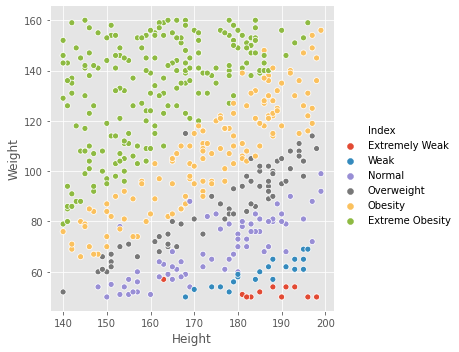

In [9]:
# 查看‘weight’和‘Height’之间的关系
sns.relplot(data=data_ana, y='Weight', x='Height', hue='Index',)

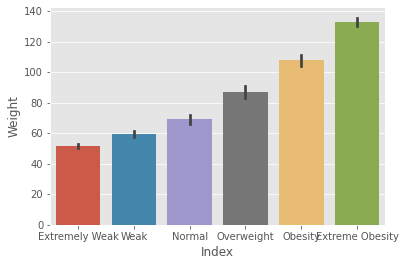

In [10]:
# 查看‘Index'各种类别‘Weight’均值对比
sns.barplot(data=data_ana, x='Index', y='Weight')

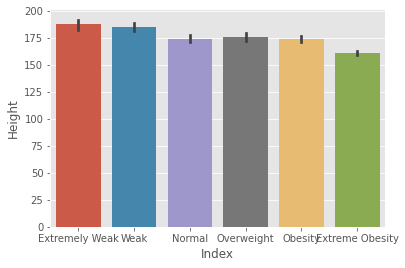

In [11]:
# 查看‘Index'各种类别‘Height’均值对比
sns.barplot(data=data_ana, x='Index', y='Height')

In [12]:
# 由上面2图可见，'Weight'均值对比更加明显

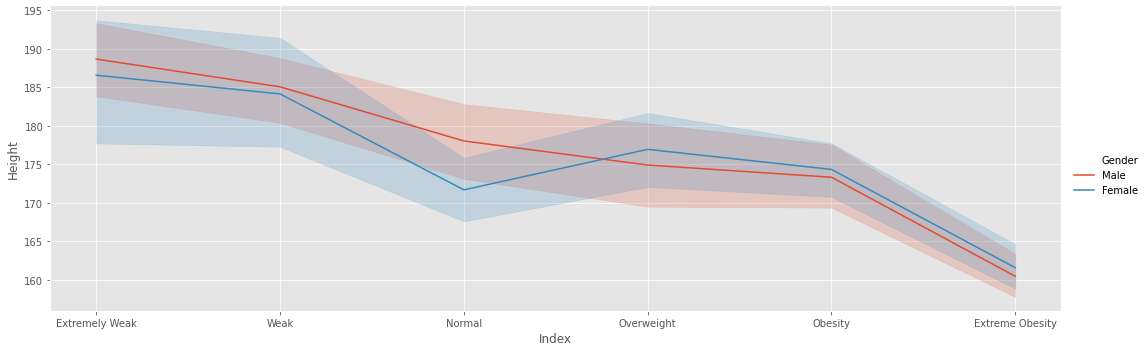

In [13]:
# ‘Index'和’Height‘之间的关系图，男女分别显示。
sns.relplot(x='Index', y='Height', data=data_ana, kind='line', aspect=3, hue='Gender')

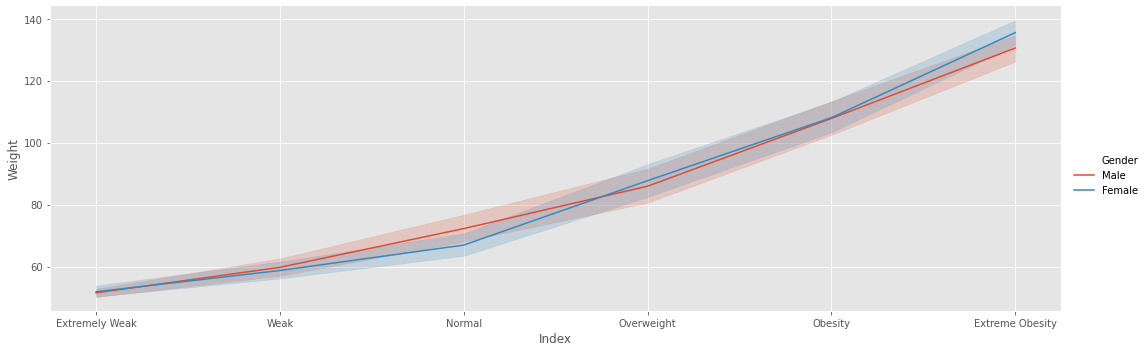

In [14]:
# 'Index' 和 ‘Weight’ 之间的关系
sns.relplot(x='Index', y='Weight', data=data_ana, kind='line', aspect=3, hue='Gender')

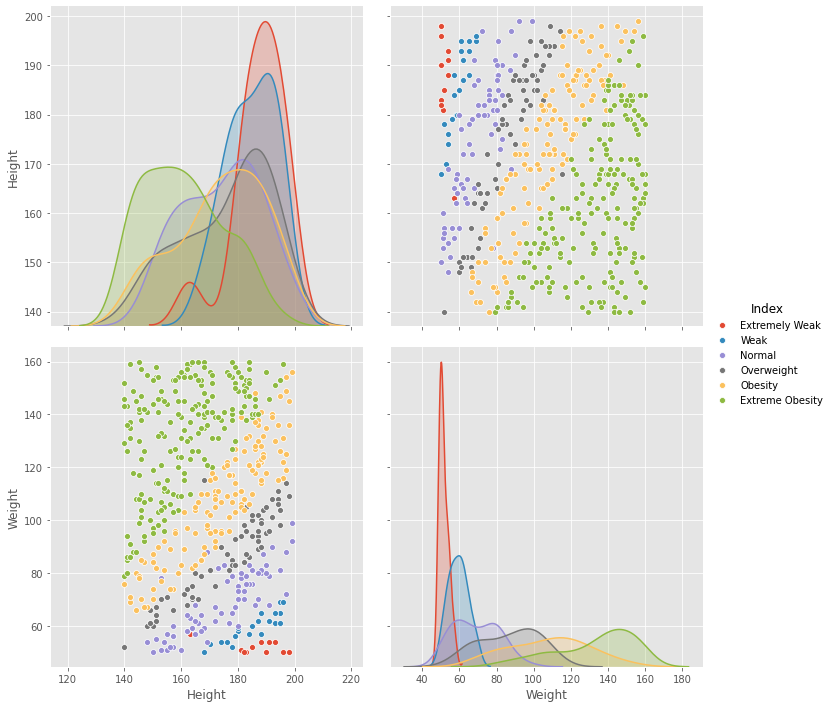

In [15]:
# ‘Weight’和‘Height’之间的关系图
sns.pairplot(data_ana, hue='Index', size=5)

## Encoding 'Gender'特征值

In [16]:
from sklearn.preprocessing import LabelEncoder 
label = LabelEncoder()
data_ana['Gender'] = label.fit_transform(data_ana['Gender'])
data_ana.head()

,Gender,Height,Weight,Index
0,1,174,96,Obesity
1,1,189,87,Normal
2,0,185,110,Obesity
3,0,195,104,Overweight
4,1,149,61,Overweight


## 重要特征值的分析

In [17]:
from sklearn.ensemble import ExtraTreesClassifier
clf_et = ExtraTreesClassifier()

In [18]:
X = data_ana.drop('Index', axis=1)
y = data_ana['Index']
clf_et.fit(X, y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

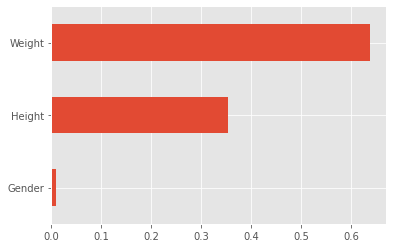

In [19]:
feature = pd.Series(clf_et.feature_importances_, index=X.columns)
feature.plot(kind='barh')

可见'Weight'对‘Index’分类的重要性是最高的。

## 分别使用XGBoost，SVM，RandomForest建模

In [20]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score

In [22]:
X = data_ana.drop('Index', axis=1)
y = data_ana['Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
ssc = StandardScaler()
X_train = ssc.fit_transform(X_train)
X_test = ssc.transform(X_test)

### XGBoost建模

In [24]:
clf_xgb = XGBClassifier()

In [25]:
clf_xgb.fit(X_train, y_train)
pred1 = clf_xgb.predict(X_test)

In [26]:
print(classification_report(y_test, pred1))

                 precision    recall  f1-score   support

Extreme Obesity       0.90      0.95      0.92        58
 Extremely Weak       1.00      1.00      1.00         1
         Normal       1.00      0.75      0.86        28
        Obesity       0.90      0.78      0.84        46
     Overweight       0.63      1.00      0.77        12
           Weak       0.62      1.00      0.77         5

       accuracy                           0.87       150
      macro avg       0.84      0.91      0.86       150
   weighted avg       0.89      0.87      0.87       150



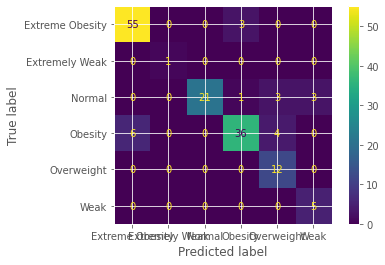

In [27]:
plot_confusion_matrix(clf_xgb, X_test, y_test,)

In [28]:
print(accuracy_score(y_test, pred1))

0.8666666666666667


   ### RandomForest建模

In [29]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
pred2 = clf_rf.predict(X_test)

In [30]:
print(classification_report(y_test, pred2))

                 precision    recall  f1-score   support

Extreme Obesity       0.92      0.93      0.92        58
 Extremely Weak       1.00      1.00      1.00         1
         Normal       1.00      0.75      0.86        28
        Obesity       0.88      0.80      0.84        46
     Overweight       0.63      1.00      0.77        12
           Weak       0.62      1.00      0.77         5

       accuracy                           0.87       150
      macro avg       0.84      0.91      0.86       150
   weighted avg       0.89      0.87      0.87       150



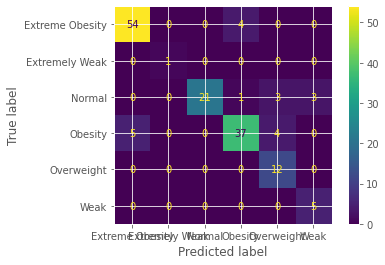

In [31]:
plot_confusion_matrix(clf_rf, X_test, y_test)

In [32]:
print(accuracy_score(y_test, pred2))

0.8666666666666667


### SVM建模

In [33]:
svc = SVC()
svc.fit(X_train, y_train)
pred3 = svc.predict(X_test)

In [34]:
print(classification_report(y_test, pred3))

                 precision    recall  f1-score   support

Extreme Obesity       0.96      0.93      0.95        58
 Extremely Weak       0.00      0.00      0.00         1
         Normal       0.90      0.68      0.78        28
        Obesity       0.89      0.85      0.87        46
     Overweight       0.43      0.83      0.57        12
           Weak       0.83      1.00      0.91         5

       accuracy                           0.85       150
      macro avg       0.67      0.72      0.68       150
   weighted avg       0.88      0.85      0.85       150



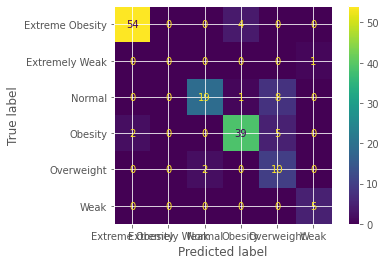

In [35]:
plot_confusion_matrix(svc, X_test, y_test)

In [36]:
print(accuracy_score(y_test, pred3))

0.8466666666666667


由于数据量较少，特征值不多，所以3个分类器的分数很接近。